<a href="https://colab.research.google.com/github/Pawanme9034/sentiment_analysis_US_Airline_tweets/blob/main/Assignment_Solution_Support_Vector_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <u><b> Objective </b></u>
## <b> You are given a data of US Airline tweets and their sentiment. The task is to do sentiment analysis about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service"). </b>

<br>
<br>

## <b>Things to do :</b>
* ### Read the tweets.csv data, clean and tokenize the tweets using nltk library.
* ### Count vectorize the tweets so that you end up with a sparse matrix (which will be your $X$).
* ### You are supposed to build a SVM classifier (a binary classification in fact). Since the data contains three levels of sentiment(positive, negative and neutral), you should remove the sentences which are neutral. Once you do that you will have two classes only (positive and negative). You can set the label of positive tweets to 1 and negative tweets to 0.
* ### Once you have built the SVM classifier, evaluate this model across various metrics. Also plot the ROC curve and Precision-Recall curve. Report the areas under these two curves along with other metrics.
* ### Perform GridSearch cross validation for various values of $C$ and $gamma$. These will be the hyperparameters which you would play around with.
* ### Explain your observations and the underlying reasons for these.
* ### Try checking if <code>tfidfvectorizer</code> helps you gain lift in model's performance.





In [4]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc

from sklearn.svm import SVC #Support vector classifier


In [5]:
# Load Dataset
import requests
from io import StringIO
# uploading data through Github directly
url = "https://raw.githubusercontent.com/Pawanme9034/sentiment_analysis_US_Airline_tweets/main/Tweets.csv"
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0"}
req = requests.get(url, headers=headers)
data = StringIO(req.text)

df=pd.read_csv(data)

In [6]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

We are mainly concerned with the airline sentiment and text column which look fine based on info.

In [8]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


<Axes: xlabel='airline_sentiment', ylabel='count'>

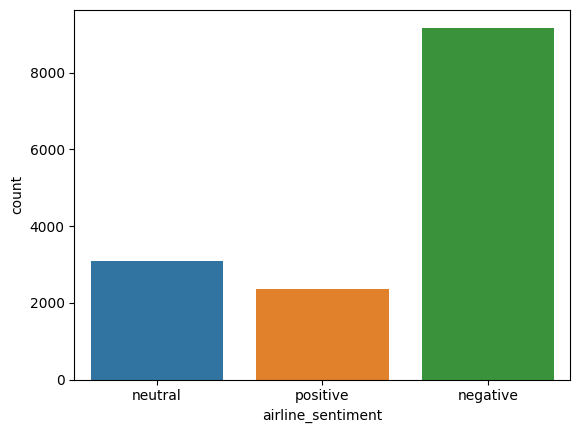

In [9]:
sns.countplot(x=df['airline_sentiment'])

Most tweets are negative according to the airline.

In [10]:
df['length']=df['text'].apply(len)


<Axes: ylabel='Frequency'>

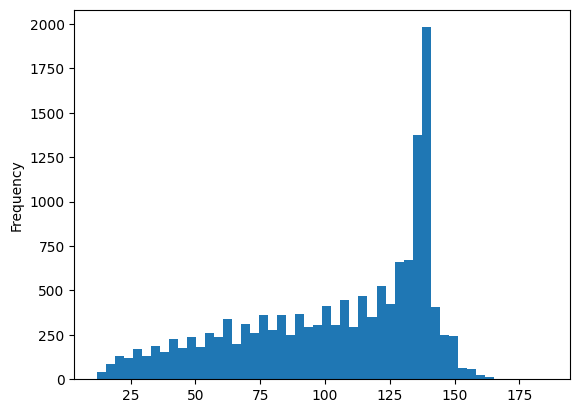

In [11]:
df['length'].plot(bins=50,kind='hist')

In [12]:
df['length'].describe()

count    14640.000000
mean       103.822063
std         36.277339
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: length, dtype: float64

In [13]:
df[df['length']==186]['text'].iloc[0]

"@USAirways Eyyyy! Cancelled Flightlations, Flight Booking Problemss, reFlight Booking Problemss, but y'all got me on the same flight out tonight (not tomorrow) &amp; the FC upgrade. Thx!"

##**Text Pre-Processing**

In [14]:
#Get rid of stop words and punctuations
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
import string
from nltk.corpus import stopwords

In [16]:
stopset=stopwords.words('english')

In [17]:
#Function to remove punctuations
def text_process(msg):
    nopunc =[char for char in msg if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

In [18]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,length
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),35
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),72
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),71
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),126
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),55


##**Tokenization**

In [19]:
pd.set_option('display.max_colwidth', -1)

<ipython-input-19-0891b765a168>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [ ]:
#Remove punctuations and special characters and stop words.
df['tokenized_tweet'] = df['text'].apply(text_process)

#**No neutrals allowed!**

In [ ]:
df = df[df.airline_sentiment	 != 'neutral'].reset_index()


##**Let's just get rid of unwanted columns..its time.**

In [ ]:
tweet=df[['airline_sentiment','tokenized_tweet','length']]

In [ ]:
tweet.head()

In [ ]:
tweet.tail()

In [ ]:
tweet.info()

In [ ]:
tweet.head()

##**Vectorization**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
#X = vectorizer.fit_transform(tweet['tokenized_tweet'])

In [ ]:
#X = tweet['tokenized_tweet']
#Y = tweet['airline_sentiment']

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(tweet['tokenized_tweet'],tweet['airline_sentiment'],test_size=0.4)

In [ ]:
x_train.head()

In [ ]:
x_test.head()

In [ ]:
train_vectorized = vectorizer.fit_transform(x_train)
test_vectorized = vectorizer.transform(x_test)


In [ ]:
train_vectorized

In [ ]:
test_vectorized

In [ ]:
from sklearn import svm
clf = svm.SVC()


In [ ]:
 clf.fit(train_vectorized, y_train)

In [ ]:
train_pred=clf.predict(train_vectorized)

In [ ]:
test_pred=clf.predict(test_vectorized)

In [ ]:
# Confusion matrices for train and test

print(confusion_matrix(y_train,train_pred))
print(confusion_matrix(y_test,test_pred))

##**Roc and precison recall curve for train data.**


In [ ]:
from sklearn import datasets, metrics, model_selection, svm
metrics.plot_roc_curve(clf, train_vectorized, y_train)


In [ ]:
metrics.plot_precision_recall_curve(clf, train_vectorized, y_train)


##**Roc and precison recall curve for test data.**

In [ ]:
metrics.plot_roc_curve(clf, test_vectorized, y_test)


In [ ]:
metrics.plot_precision_recall_curve(clf, test_vectorized, y_test)

In [ ]:
# Print the classification report for train and test
print(classification_report(y_train,train_pred))
print("\n")
print(classification_report(y_test,test_pred))

##Grid search cv

In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
param_dict = {'C': [0.1, 1, 10, 1000],
              'gamma': [1, 0.1, 0.01, 0.0001],
              'kernel': ['rbf','linear','poly']}

In [ ]:
grid = GridSearchCV(clf, param_dict,n_jobs=2, cv=5, verbose = 10,scoring='accuracy')


In [ ]:
grid.fit(train_vectorized,y_train)

In [ ]:
grid.best_params_

In [ ]:
g_pred_tr=grid.predict(train_vectorized)

In [ ]:
g_pred_test=grid.predict(test_vectorized)

In [ ]:
# Confusion matrices for train and test

print(confusion_matrix(y_train,g_pred_tr))
print(confusion_matrix(y_test,g_pred_test))

In [ ]:
# Print the classification report for train and test
print(classification_report(y_train,g_pred_tr))
print("\n")
print(classification_report(y_test,g_pred_test))

##**Roc and precison recall curve for grid train data.**


In [ ]:
from sklearn import datasets, metrics, model_selection, svm
metrics.plot_roc_curve(grid, train_vectorized, y_train)


In [ ]:
metrics.plot_precision_recall_curve(grid, train_vectorized, y_train)


##**Roc and precison recall curve for grid test data.**


In [ ]:
metrics.plot_precision_recall_curve(grid, test_vectorized, y_test)


In [ ]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(grid, test_vectorized, y_test)


##**Vectorize using TFIDF vectorizer.**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vectorizer = TfidfVectorizer(use_idf=True, lowercase=True, strip_accents='ascii', stop_words=stopset)

In [ ]:
X = tf_vectorizer.fit_transform(tweet.tokenized_tweet)
y = tweet.airline_sentiment

In [ ]:
max(tf_vectorizer.get_feature_names())


In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.4)


In [ ]:
clf_tf = svm.SVC()


In [ ]:
clf_tf.fit(X_train,Y_train)

In [ ]:
tf_train_pred=clf_tf.predict(X_train)

In [ ]:
tf_train_pred

In [ ]:
tf_test_pred=clf_tf.predict(X_test)

In [ ]:
# Confusion matrices for train and test

print(confusion_matrix(Y_train,tf_train_pred))
print(confusion_matrix(Y_test,tf_test_pred))

In [ ]:
# Print the classification report for train and test
print(classification_report(y_train,tf_train_pred))
print("\n")
print(classification_report(y_test,tf_test_pred))

##**Roc and precison recall curve for Tfidf train data.**


In [ ]:
metrics.plot_roc_curve(clf_tf, X_train, Y_train)


In [ ]:
plot_precision_recall_curve(clf_tf, X_train, Y_train)


##**Roc and precison recall curve for Tfidf test data.**


In [ ]:
metrics.plot_roc_curve(clf_tf, X_test, Y_test)


In [ ]:
plot_precision_recall_curve(clf_tf, X_test, Y_test)


##Apply grid parameters

In [ ]:
param_dict = {'C': [0.1, 1, 10, 1000],
              'gamma': [1, 0.1, 0.01, 0.0001],
              'kernel': ['rbf','linear','poly']}



In [ ]:
grid_tf = GridSearchCV(clf, param_dict,n_jobs=2, cv=5, verbose = 10,scoring='accuracy')


In [ ]:
grid_tf.fit(X_train,Y_train)

In [ ]:
gridtf_train_pred=grid_tf.predict(X_train)

In [ ]:
gridtf_test_pred=grid_tf.predict(X_test)

In [ ]:
# Confusion matrices for train and test

print(confusion_matrix(Y_train,gridtf_train_pred))
print(confusion_matrix(Y_test,gridtf_test_pred))

In [ ]:
# Print the classification report for train and test
print(classification_report(Y_train,gridtf_train_pred))
print("\n")
print(classification_report(Y_test,gridtf_test_pred))

##**Roc and precison recall curve for train and test data.**


In [ ]:
metrics.plot_roc_curve(grid_tf, X_train, Y_train)


In [ ]:
plot_precision_recall_curve(grid_tf, X_train, Y_train)


In [ ]:
metrics.plot_roc_curve(grid_tf, X_test, Y_test)


In [ ]:
plot_precision_recall_curve(grid_tf, X_test, Y_test)


##Based on the metrics all the models are doing well on train as well as test data.